# Bird Simulation Evaluation Script

## Imports & Preparations

In [1]:
import numpy as np
import scipy as sp
import birds
import argparse
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.animation import FuncAnimation
from matplotlib.collections import PathCollection
from IPython.display import HTML
from scipy.optimize import curve_fit
#%matplotlib ipympl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Figure output Settings

In [2]:
figpath = '../img/'
figwidth = 4 #figure width in inches
figsize = (figwidth,figwidth*2.5/4)

## Run with default Settings

In [ ]:
frames = 1000
birds.param_record = False
birds.trace = None
birds.flock = birds.Flock()
fig = plt.figure(figsize=(5, 5*birds.flock.args['height']/birds.flock.args['width']), facecolor="white")
ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], aspect=1, frameon=False)
birds.collection = birds.MarkerCollection(birds.flock.args['n'])
ax.add_collection(birds.collection._collection)
ax.set_xlim(0, birds.flock.args['width'])
ax.set_ylim(0, birds.flock.args['height'])
ax.set_xticks([])
ax.set_yticks([])

animation = FuncAnimation(fig, birds.update, interval=10, frames=frames)
HTML(animation.to_html5_video())


## Find moving phase

## Run with varying Eta

In [3]:
def avg_with_error(f, avg_time):
    var = np.zeros(avg_time)
    va_avg = 0
    for t in range(avg_time):
        va_tmp = f.get_va()
        va_avg += va_tmp
        var[t] = va_tmp
        f.run()
    va_avg /= avg_time
    var = np.sum((var-va_avg)**2 / avg_time)
    return va_avg, var

In [14]:
res = 20
time = 1500
averaging_time = 1000
repeat = 3
rho=4
Eta = np.linspace(0.,5.,res)
N = [40,100,400]


        
        

va = np.zeros((len(N),res))
vas = np.zeros(repeat)
errorbars = np.zeros_like(va)
variance = np.zeros(repeat)
for c,n in enumerate(N):
    for i,eta in enumerate(Eta):
        for j in range(repeat):
            f = birds.Flock(n=n,eta=eta,rho=rho)
            for t in range(time):
                f.run()
            va_avg, vari = avg_with_error(f, averaging_time)
            vas[j] = va_avg
            variance[j] = vari
        va[c][i] = vas.sum()/repeat
        errorbars[c][i] = np.sqrt(variance.sum()/repeat)
        
print('Has been run.')

Has been run.


In [39]:
print(Eta)
print(va[0])

[ 0.          0.27586207  0.55172414  0.82758621  1.10344828  1.37931034
  1.65517241  1.93103448  2.20689655  2.48275862  2.75862069  3.03448276
  3.31034483  3.5862069   3.86206897  4.13793103  4.4137931   4.68965517
  4.96551724  5.24137931  5.51724138  5.79310345  6.06896552  6.34482759
  6.62068966  6.89655172  7.17241379  7.44827586  7.72413793  8.        ]
[ 0.97655204  0.73272548  0.48661571  0.81432589  0.5074891   0.51070998
  0.56949235  0.49639655  0.30140368  0.30672112  0.31780546  0.16214359
  0.17626402  0.072703    0.06632317  0.06316466  0.06265458  0.06404038
  0.06520254  0.06628658  0.06696235  0.06740971  0.06857165  0.06968696
  0.06912173  0.07163323  0.07216833  0.07557235  0.0737759   0.07306138]


### Fit $\eta_c$

In [89]:
# Define fit functions
def finvsquare(x, sqwidth):
    return 1-(x*sqwidth)**2

def flin(x, m, b):
    return m*x+b

def fphase(x, eta_c, beta):
    return (eta_c - x)**beta

# find array index of eta_c as first approx to split fit in linear- and phase-relation-parts
vamin = np.argmin(va[0])
linparams = sp.optimize.curve_fit(flin,Eta[vamin:len(Eta)],va[0][vamin:len(va[0])],p0=[0.2,-0.5],sigma=errorbars[0][vamin:len(errorbars[0])])
valin = flin(Eta,*linparams[0])
eta_c_ind = np.where(np.absolute(va[0]-valin) < errorbars[0])[0][0]
print(eta_c_ind)

# fit it with square + line
sqwidth = sp.optimize.curve_fit(finvsquare,Eta[0:eta_c_ind],va[0][0:eta_c_ind],p0=1/6,sigma=errorbars[0][0:eta_c_ind])
linparams = sp.optimize.curve_fit(flin,Eta[eta_c_ind:len(Eta)],va[0][eta_c_ind:len(va[0])],p0=[0.2,-0.5],sigma=errorbars[0][eta_c_ind:len(errorbars[0])])

# calculate second approx for eta_c from fit
p,q = linparams[0][0]/sqwidth[0]**2,(linparams[0][1]-1)/sqwidth[0]**2
eta_c_0 = -p/2 + np.sqrt((p/2)**2 - q)

valog = np.log(va[0][0:eta_c_ind])
etalog = np.log(eta_c_0-Eta[0:eta_c_ind],where=Eta[0:eta_c_ind] < eta_c_0)
print(valog)
print(etalog)
print(valog/etalog)

13
[-0.02372724 -0.31098416 -0.72028056 -0.20539463 -0.67828005 -0.67195341
 -0.56300992 -0.70038017 -1.19930479 -1.18181636 -1.14631585 -1.81927298
 -1.73577231]
[  1.07482851e+00   9.75927911e-01   8.66161530e-01   7.42843725e-01
   6.02150888e-01   4.38371133e-01   2.42411176e-01  -1.54520768e-03
  -3.24907879e-01  -8.05796758e-01  -1.76685354e+00   1.57897105e+01
   1.27300046e+01]
[ -2.20753713e-02  -3.18654849e-01  -8.31577644e-01  -2.76497770e-01
  -1.12642871e+00  -1.53284138e+00  -2.32254111e+00   4.53259569e+02
   3.69121484e+00   1.46664322e+00   6.48789401e-01  -1.15218894e-01
  -1.36352842e-01]


In [74]:
# fit beta
def fphase_temp(x, beta):
    return fphase(x,eta_c_0,beta)
beta_0 = sp.optimize.curve_fit(fphase_temp,Eta[0:eta_c_ind],va[0][0:eta_c_ind],p0=0.45,sigma=errorbars[0][0:eta_c_ind])[0]
beta_0

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in power
/usr/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


array([ 0.45])

In [18]:
# fit eta_c and beta using former fits as start values
phaseparams = sp.optimize.curve_fit(fphase,Eta[0:vamin-1],va[0][0:vamin-1],p0=[eta_c_0,beta_0],sigma=errorbars[0][0:vamin-1])
phaseparams

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in power
/usr/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(array([ 3.5091865,  0.45     ]), array([[ inf,  inf],
        [ inf,  inf]]))

### Plot $v_a$ over $\eta$

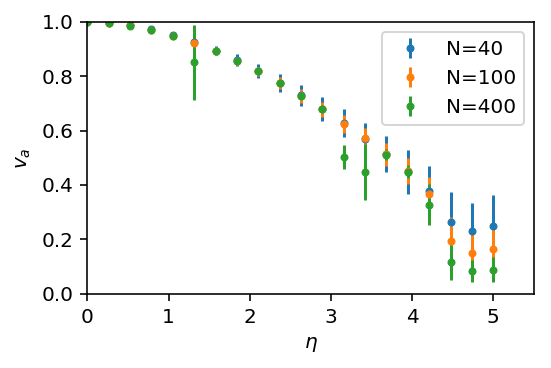

In [15]:
plt.figure(figsize=figsize)
for c,n in enumerate(N):
    plt.errorbar(Eta, va[c], yerr=errorbars[c], fmt='.', label="N="+str(n))
#plt.plot(Eta,finvsquare(Eta,sqwidth[0]), label='Square Fit')
#plt.plot(Eta,fphase(Eta,*phaseparams[0]), label='Phase relation Fit')
#plt.plot(Eta,flin(Eta,*linparams[0]), label='linear Fit')

plt.xlabel("$\\eta$")
plt.ylabel("$v_a$")
plt.xlim([0,5.5])
plt.ylim([0,1])
plt.legend()

plt.savefig(figpath+'va_over_eta.eps')

### Plot $v_a$ over $(\eta_c - \eta)/\eta_c)$

eta_c=4.5


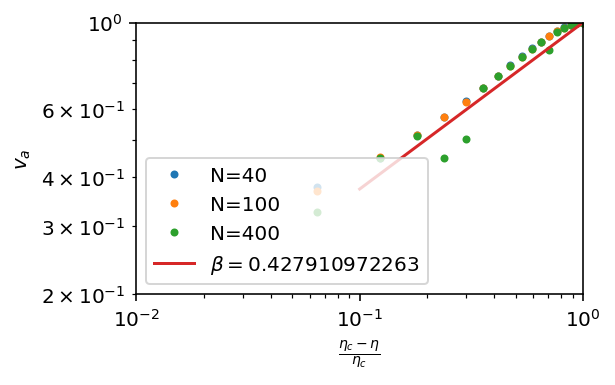

In [16]:
plt.figure(figsize=figsize)
plt.ylim(ymin=0.2)
plt.xlim(xmin=0.01)
eta_c = 4.5  # This is a guess of the critical eta value. There must be a better way of determining it
for c,n in enumerate(N):
    plt.plot( (eta_c-Eta)/eta_c, va[c],'.',label="N="+str(n))
ca = plt.gca()
ca.set_xscale('log')
ca.set_yscale('log')
plt.xlabel("$\\frac{\\eta_c - \\eta}{\\eta_c}$")
plt.ylabel("$v_a$")



x = (eta_c-Eta)/eta_c
select = x > 0
x = np.log(x[select])
y = np.log(va[-1][select])
coef = np.polyfit(x,y,1)
plt.plot(np.logspace(-1,0,10), np.logspace(-1,0,10)**coef[0], label="$\\beta=$"+str(coef[0]))
plt.legend();

# if you come up with a better naming scheme PLEASE change this
plt.savefig(figpath+'va_over_etac_minus_eta_over_etac.eps')
print('eta_c='+str(eta_c))

## Run with varying density

In [19]:
res = 15
time = 1000
averaging_time = 500
repeat = 5
eta = .3
Rho = np.logspace(-3,0.2, res)
N = [50]

va = np.zeros((len(N), res))
vas = np.zeros(repeat)
errorbars = np.zeros_like(va)
variance = np.zeros(repeat)
for c,n in enumerate(N):
    for i,rho in enumerate(Rho):
        for j in range(repeat):
            f = birds.Flock(n=n, eta=eta, rho=rho)
            for t in range(time):
                f.run()
            va_avg, vari = avg_with_error(f, averaging_time)
            vas[j] = va_avg
            variance[j] = vari
        va[c][i] = vas.sum()/repeat
        errorbars[c][i] = np.sqrt(variance.sum()/repeat)


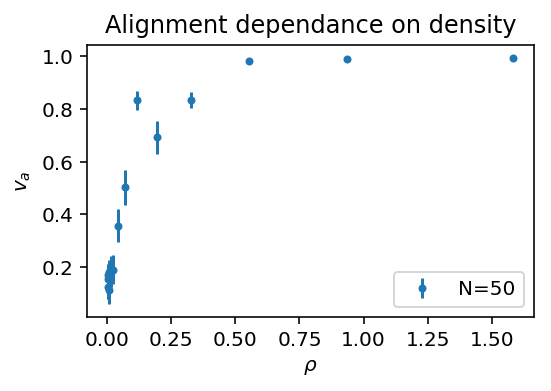

In [20]:
plt.figure(figsize=figsize)
for c,n in enumerate(N):
    plt.errorbar(Rho, va[c], yerr=errorbars[c], fmt='.', label="N="+str(n))

plt.xlabel("$\\rho$")
plt.ylabel("$v_a$")
plt.legend()
plt.title("Alignment dependance on density");

plt.savefig(figpath+'va_over_rho.eps')

## Run with varying angle

This has to be done for low rho and eta. This should be evident from the graphs above as a high value of eta reduces the alignment going to almost zero.

A high density causes more alignment, and thus if we attempt running with higher densities, they all align anyway.

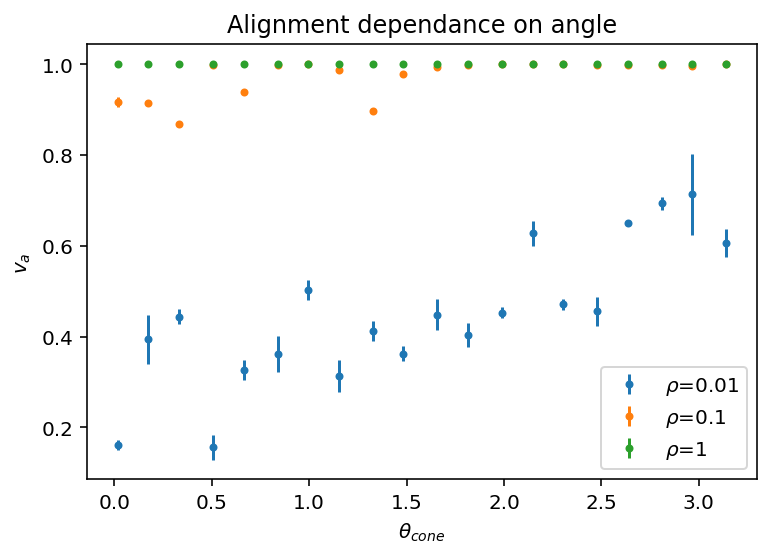

In [8]:
res = 20
time = 1000
averaging_time = 1000
repeat = 3
eta = 0
Angle = np.linspace(1,180,res,dtype=int)
Rho= [0.01,0.1,1] # np.logspace(-3, 0, 5)
n = 100

va = np.zeros((len(Rho), res))
vas = np.zeros(repeat)
errorbars = np.zeros_like(va)
variance = np.zeros(repeat)
for c,rho in enumerate(Rho):
    for i,angle in enumerate(Angle):
        for j in range(repeat):
            f = birds.Flock(n=n, eta=eta, rho=rho, angle=angle)
            for t in range(time):
                f.run()
            va_avg, vari = avg_with_error(f, averaging_time)
            vas[j] = va_avg
            variance[j] = vari
        va[c][i] = vas.sum()/repeat
        errorbars[c][i] = np.sqrt(variance.sum()/repeat)

plt.figure()
for c,rho in enumerate(Rho):
    plt.errorbar(Angle/360*2*np.pi, va[c], yerr=errorbars[c], fmt='.', label="$\\rho$="+str(np.round(rho,decimals=4)))
plt.xlabel("$\\theta_{cone}$")
plt.ylabel("$v_a$")
plt.legend()
plt.title("Alignment dependance on angle");

plt.savefig(figpath+'va_over_angle.eps')